#  Abstractive Summarization of Long Podcast Transcripts with BART using Semantic Self-segmentation
Podcasts are a rapidly growing medium for news, commentary, entertainment, and learning.  Some podcast shows release new episodes on a regular schedule (daily, weekly, etc); others irregularly.  Some podcast shows feature short episodes of 5 minutes or less touching on one or two topics; others may release 3+ hour long episodes touching on a wide range of topics.  Some are structured as news delivery, some as conversations, some as storytelling.

Given a podcast episode, its audio, and transcription, return a short text snippet capturing the most important information in the content. Returned summaries should be grammatical, standalone statement of significantly shorter length than the input episode description.

The user task is to provide a short text summary that the user might read when deciding whether to listen to a podcast. Thus the summary should accurately convey the content of the podcast, and be short enough to quickly read on a smartphone screen. It should also be human-readable.

For further information about the challenge, take a look to Podcasts Track Guidelines:
- [TREC 2020 Podcasts Track](https://trecpodcasts.github.io/participant-instructions-2020.html)

In [80]:
import numpy as np
import os
import pandas as pd
import regex as re
import json
import random
from tqdm import tqdm
from difflib import SequenceMatcher

import tensorflow as tf
from tensorflow import keras

import pysbd
from sentence_transformers import SentenceTransformer, util
from datasets import Dataset
from transformers import AutoTokenizer

# Register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
tqdm.pandas()

## 1. Dataset preparation

### 1.1 Dataset reading

In [10]:
dataset_path = os.path.join(os.path.abspath(""), 'podcasts-no-audio-13GB')

metadata_path_train = os.path.join(dataset_path, 'metadata.tsv')
metadata_train = pd.read_csv(metadata_path_train, sep='\t')
print("Columns: ", metadata_train.columns)
print("Shape: ", metadata_train.shape)

Columns:  Index(['show_uri', 'show_name', 'show_description', 'publisher', 'language',
       'rss_link', 'episode_uri', 'episode_name', 'episode_description',
       'duration', 'show_filename_prefix', 'episode_filename_prefix'],
      dtype='object')
Shape:  (105360, 12)


In [3]:
def get_path(episode):
    """
    Get the path of the episode json file
    
    Parameters
    ----------
    episode : pandas.Series
        A row from the metadata file

    Returns
    -------
    path : str
        The absolute path of the episode json file
    """
    # extract the 2 reference number/letter to access the episode transcript
    show_filename = episode['show_filename_prefix']
    episode_filename = episode['episode_filename_prefix'] + ".json"
    dir_1, dir_2 = re.match(r'show_(\d)(\w).*', show_filename).groups()

    # check if the transcript file in all the derived subfolders exist
    transcipt_path = os.path.join(dataset_path, "spotify-podcasts-2020",
                                "podcasts-transcripts", dir_1, dir_2,
                                show_filename, episode_filename)
    return transcipt_path

def get_transcription(episode):
    """
    Extract the transcript from the episode json file
    
    Parameters
    ----------
    episode : pandas.Series
        A row from the metadata file
    
    Returns
    -------
    transcript : str
        The transcript of the episode
    """
    with open(get_path(episode), 'r') as f:
        episode_json = json.load(f)
        # seems that the last result in each trastcript is a repetition of the first one, so we ignore it
        transcripts = [
            result["alternatives"][0]['transcript'] if 'transcript' in result["alternatives"][0] else ""
            for result in episode_json["results"][:-1]
        ]
        return " ".join(transcripts)

### 1.2 Dataset analysis

<AxesSubplot:>

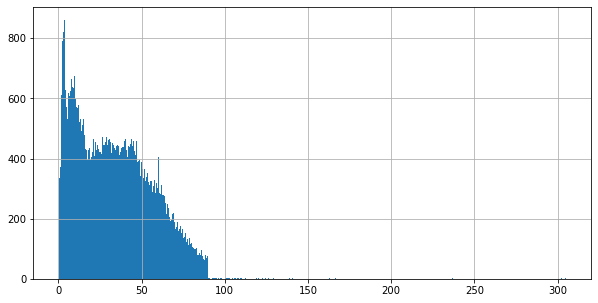

In [6]:
metadata_train['duration'].hist(bins=1000, figsize=(10,5))

### 1.3 Dataset cleaning

Some of the episodes contain a `NaN` value in the `episode_description` and `show_description` columns. Let's remove them.

In [11]:
print("Before dropping NaN values: \n", metadata_train.isna().any())
metadata_train.dropna(subset=['episode_description', 'show_description'], inplace=True)
print("\nAfter dropping NaN values:\n", metadata_train.isna().any())

Before dropping NaN values: 
 show_uri                   False
show_name                  False
show_description            True
publisher                  False
language                   False
rss_link                   False
episode_uri                False
episode_name               False
episode_description         True
duration                   False
show_filename_prefix       False
episode_filename_prefix    False
dtype: bool

After dropping NaN values:
 show_uri                   False
show_name                  False
show_description           False
publisher                  False
language                   False
rss_link                   False
episode_uri                False
episode_name               False
episode_description        False
duration                   False
show_filename_prefix       False
episode_filename_prefix    False
dtype: bool


In order to select a subset of the corpus that is suitable for training supervised models, we filtered the descriptions using three heuristics shown in the table below. These filters overlap to some extent, and remove about a third of the entire set. The remaining 66,245 descriptions we call the Brass Set.

| Criterion                        | Threshold                                                    |
| -------------------------------- | ------------------------------------------------------------ |
| Length                           | descriptions that are very long (> 750 characters) or short (< 20 characters) amounting to 24033 or 23% of the descriptions. |
| Similarity to show description   | descriptions with high lexical overlap (over 40%) with their show description, amounting to 9444 or 9% of the descriptions. |
| Similarity to other descriptions | descriptions with high lexical overlap (over 50%) with other episode descriptions amounting 15375 or 15% of the descriptions. |


In [110]:
def check_lenght_brass(episode, upper_bound=750, lower_bound=20):
    """
    Check if the episode descriptions is not too long (> 750 characters) or not too short (< 20 characters)

    Parameters
    ----------
    episode : pandas.Series
        A row from the metadata file
    upper_bound : int
        The upper bound of the episode description length
    lower_bound : int
        The lower bound of the episode description length
    
    Returns
    -------
    Boolean indicating if the episode description is long enough
    """
    return len(episode['episode_description']) <= upper_bound and len(episode['episode_description']) >= lower_bound
    
def description_similarity(a, b):
    """
    Measure the overlapping between two descriptions

    Parameters
    ----------
    a : str
        The first description
    b : str
        The second description
    
    Returns
    -------
    Value indicating the overlapping between the two descriptions
    """
    return SequenceMatcher(None, a, b).ratio()

def check_show_description_overlap_brass(episode, thresh=0.4):
    """
    Check if the episode descriptions overlapping with the show description is not too high (< 0.4)

    Parameters
    ----------
    episode : pandas.Series
        A row from the metadata file
    thresh : float
        The threshold of the overlap between the episode description and the show description

    Returns
    -------
    Boolean indicating if the episode description is different enough from the show description
    """
    return description_similarity(episode['show_description'], episode['episode_description']) < thresh
    
def check_other_description_overlap_brass(episode, all_episodes, thresh=0.5):
    """
    Check if the episode descriptions overlapping with the other description is not too high (< 0.5)

    Parameters
    ----------
    episode : pandas.Series
        A row from the metadata file
    all_episodes : pandas.DataFrame
        A dataframe containing all the episodes
    thresh : float
        The threshold of the overlap between the episode description and the other description
    
    Returns
    -------
    Boolean indicating if the episode description is different enough from the other description
    """
    other_descriptions = all_episodes[all_episodes['episode_filename_prefix'] != episode['episode_filename_prefix']]['episode_description'].values
    
    # sample the 5% of the other descriptions due to the fact that the dataset is huge
    sample_size = int(len(other_descriptions)*0.05) 
    other_descriptions_sample = random.sample(list(other_descriptions), sample_size)

    for other in other_descriptions_sample:
        if description_similarity(episode['episode_description'], other) > thresh:
            return False
    return True


brass_set_lenght = metadata_train[metadata_train.progress_apply(check_lenght_brass, axis=1)]
print(f"Removed {len(metadata_train) - len(brass_set_lenght)} episodes because of too long or too short descriptions")

brass_set_show_overlap = brass_set_lenght[brass_set_lenght.progress_apply(check_show_description_overlap_brass, axis=1)]
print(f"Removed {len(brass_set_lenght) - len(brass_set_show_overlap)} episodes because of too high overlap with the show description")

#brass_set = brass_set_show_overlap[brass_set_show_overlap.progress_apply(lambda x: check_other_description_overlap_brass(x, brass_set_show_overlap), axis=1)]
#print(f"Removed {len(brass_set_show_overlap) - len(brass_set)} episodes because of too high overlap with other descriptions")

100%|██████████| 105153/105153 [00:01<00:00, 76314.31it/s]


Removed 25478 episodes because of too long or too short descriptions


100%|██████████| 79675/79675 [00:48<00:00, 1643.71it/s]

Removed 4221 episodes because of too high overlap with the show description


In [72]:
# look to the removed episode descriptions
look = pd.concat([brass_set_lenght,brass_set_show_overlap]).drop_duplicates(keep=False)[['show_description', 'episode_description']]
look['overlapping'] = look.apply(lambda row: description_similarity(row['show_description'], row['episode_description']), axis=1)
look.values[:10]

array([['Trans women and YouTubers Gage Adkins and Olivia Noel discuss LGBTQ+ topics/stories from their own experiences. As women of color in their early twenties, the two strive to create a podcast that speaks volumes by discussing issues like: transphobia, coming out in college, dysphoria and what it’s like being trans in the 21st century. Support this podcast: https://anchor.fm/girlish/support',
        'Welcome to Girl-ish! Trans women and YouTubers Gage Adkins and Jae Noel discuss LGBTQ+ topics/stories from their own experiences. As women of color in their early twenties, the two strive to create a podcast that speaks volumes by discussing issues like: transphobia, coming out in college, dysphoria and what it’s like being trans in the 21st century.\xa0  ---   Support this podcast: https://anchor.fm/girlish/support',
        0.9528535980148883],
       ['Follow us to enjoy hour long ASMR episodes that are posted every day! If you enjoy this make sure to give us a 5 star rating!  Su

#### 1.3.1 Further cleaning of the data
The podcast episodes should be restricted to the English language, but they cover a range of geographical regions and we found a number of non-English podcasts in the dataset. So we remove them.

Tokens that correspond to URLs, email addresses, @mentions, #hashtags, and those excessively long tokens (>25 characters) are directly removed from the summaries.

We futher cleaned the descriptions computing a *salience score* for each sentence of the description by summing over word IDF scores.
Then we remove sentences if their salience scores are lower than a threshold. 

### 1.4 Golden set integration
In addition we have a **golden set** of 150 episodes composed by 6 set of summaries for each episode (900 document-summary-grade triplets) that were graded on the Bad/Fair/Good/Excellent scale (0-3). We integrated the best summary of each episodes in the *brass set*.

### 1.5 Semantic segmentation

### 1.6  Chunck classifier

In [9]:
def look_ahead_chuck(sentences, lower_chunk_size):
    """
    Look-ahead function to determine the next chunk
    """
    if sum([len(s) for s in sentences]) < lower_chunk_size:
        # if the remaining sentences size is smaller than the lower bound, we return the remaining sentences
        return sentences
    else:
        # next chunk size should be at least the lower bound 
        for i in range(len(sentences)):
            if sum([len(s) for s in sentences[:i+1]]) >= lower_chunk_size:
                return sentences[:i+1]


def semantic_segmentation(text, model, lower_chunk_size=300, upper_chunk_size=2000):
    """
    Algorithm proposed by Moro et. al. (2022) to semantically segment long inputs into GPU memory-adaptable chunks.
    https://www.aaai.org/AAAI22Papers/AAAI-3882.MoroG.pdf

    Parameters
    -------------
    text: str
        The text to be segmented
    model: SentenceTransformer
        The model to be used for the sentence embeddings
    lower_chunk_size: int
        The lower bound of the chunk size
    upper_chunk_size: int
        The upper bound of the chunk size
    Return
    -------
    List of chunks of text
    """

    # segment the text into sentences
    seg = pysbd.Segmenter(language="en", clean=False)
    sentences = seg.segment(text)

    chuncks = []
    current_chunk = [sentences[0]]

    # Iterate over the sentences in the text
    for i, sentence in enumerate(sentences[1:]):
        if sentence == sentences[-1]:
            # If the sentence is the last one, we add it to the last chunk
            current_chunk.append(sentence)
            chuncks.append(current_chunk)
        elif sum([len(s) for s in current_chunk]) + len(sentence) < lower_chunk_size:
            # standardize each chunk to a minimum size to best leverage the capability of Transformers
            current_chunk.append(sentence)
        elif sum([len(s) for s in current_chunk]) + len(sentence) > upper_chunk_size:
            # if the chunk is too big, we add it to the list of chunks and start a new one
            chuncks.append(current_chunk)
            current_chunk = [sentence]
        else:
            idx = i+1
            next_chuck = look_ahead_chuck(sentences[idx+1:], lower_chunk_size)
            
            # get the embedding of the previous chunk and the next chunk
            current_embedding = model.encode(current_chunk)
            next_embedding = model.encode(next_chuck)
            sentence_embedding = model.encode([sentence])

            # get the cosine similarity between the embedding of the embeddings
            score_current_chunk = util.cos_sim(sentence_embedding, current_embedding).numpy().mean()
            score_next_chunk = util.cos_sim(sentence_embedding, next_embedding).numpy().mean()

            # if the score_current_chunk is higher than the score_next_chunk, we add the sentence to the current chunk
            if score_current_chunk > score_next_chunk:
                current_chunk.append(sentence)
            else:
                if sum([len(s) for s in current_chunk]) >= lower_chunk_size:
                    chuncks.append(current_chunk)
                    current_chunk = [sentence]
                else:
                    current_chunk.append(sentence)
    return chuncks

# Initialize the sentence transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")
semantic_segmentation(get_transcription(metadata_train.iloc[105325]), model)

[["Hi, I'm Ben Folds. ",
  "Welcome to a new podcast series that I'm hosting called Arts vote 2020 where I talked to presidential candidates about arts and politics this year. ",
  'I joined the board of the Americans for the Arts action fund to help artists enthusiasts like you and made a better understand where these candidates stand on the issues. ',
  'We care about former US senator and Anchorage mayor Mark begich is joining me to moderate this series as we talked to candidates about Impact of the arts and arts education our communities schools and our lives.  ',
  'I wanted to do this podcast series because I realized that if the Arts Community wants to move the needle on the future support of the Arts. ',
  'Then we need to act now to engage candidates on these issues. ',
  'Our first interviews will be with 20/20 presidential candidates. ',
  'Mayor Pete Buddha judge and congressman John Delaney. ',
  "We're going to try our best to interview everyone running for president to l

## 2. Training

In [ ]:
max_input_length = 1024
max_target_length = 256

train_dataset = Dataset.from_pandas(train_data)

model_checkpoint = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
def preprocess_function(dataset, text_column, summary_column, max_input_length, max_target_length, padding, prefix="summarize: "):
    inputs = dataset[text_column]
    targets = dataset[summary_column]
    inputs = [prefix + inp for inp in inputs]
    model_inputs = tokenizer(inputs, max_length=max_input_length, padding=padding, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, padding=padding, truncation=True)

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
padding = "max_length"
train_dataset = train_dataset.map(
                lambda x: preprocess_function(x, "transcript", "best_summary", max_input_length, max_target_length, padding, prefix="summarize: "),
                batched=True,
                remove_columns=train_dataset.column_names,
                desc="Running tokenizer on train dataset"
            )

In [ ]:
from functools import partial

def sample_generator(dataset, model, tokenizer, shuffle, pad_to_multiple_of=None):
    if shuffle:
        sample_ordering = np.random.permutation(len(dataset))
    else:
        sample_ordering = np.arange(len(dataset))
    for sample_idx in sample_ordering:
        example = dataset[int(sample_idx)]
        # Handle dicts with proper padding and conversion to tensor.
        example = tokenizer.pad(example, return_tensors="np", pad_to_multiple_of=pad_to_multiple_of)
        example = {key: tf.convert_to_tensor(arr, dtype_hint=tf.int32) for key, arr in example.items()}
        if model is not None and hasattr(model, "prepare_decoder_input_ids_from_labels"):
            decoder_input_ids = model.prepare_decoder_input_ids_from_labels(
                labels=tf.expand_dims(example["labels"], 0)
            )
            example["decoder_input_ids"] = tf.squeeze(decoder_input_ids, 0)
        yield example, example["labels"]  # TF needs some kind of labels, even if we don't use them
    return

# region Helper functions
def dataset_to_tf(dataset, model, tokenizer, total_batch_size, num_epochs, shuffle):
    if dataset is None:
        return None
    train_generator = partial(sample_generator, dataset, model, tokenizer, shuffle=shuffle)
    train_signature = {
        feature: tf.TensorSpec(shape=(None,), dtype=tf.int32)
        for feature in dataset.features
        if feature != "special_tokens_mask"
    }
    if (
        model is not None
        and "decoder_input_ids" not in train_signature
        and hasattr(model, "prepare_decoder_input_ids_from_labels")
    ):
        train_signature["decoder_input_ids"] = train_signature["labels"]
    # This may need to be changed depending on your particular model or tokenizer!
    padding_values = {
        key: tf.convert_to_tensor(tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0, dtype=tf.int32)
        for key in train_signature.keys()
    }
    padding_values["labels"] = tf.convert_to_tensor(-100, dtype=tf.int32)
    train_signature["labels"] = train_signature["input_ids"]
    train_signature = (train_signature, train_signature["labels"])
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
    tf_dataset = (
        tf.data.Dataset.from_generator(train_generator, output_signature=train_signature)
        .with_options(options)
        .padded_batch(
            batch_size=total_batch_size,
            drop_remainder=True,
            padding_values=(padding_values, np.array(-100, dtype=np.int32)),
        )
        .repeat(int(num_epochs))
    )
    return tf_dataset

In [ ]:
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
model.resize_token_embeddings(len(tokenizer))

In [ ]:
total_train_batch_size = 2
num_train_epochs = 3
learning_rate = 5e-5
tf_train_dataset = dataset_to_tf(
            train_dataset,
            model,
            tokenizer,
            total_batch_size=total_train_batch_size,
            num_epochs=num_train_epochs,
            shuffle=True,
        )

In [ ]:
from transformers import create_optimizer
# region Optimizer, loss and LR scheduling
# Scheduler and math around the number of training steps.
num_update_steps_per_epoch = len(train_dataset) // total_train_batch_size
num_train_steps = num_train_epochs * num_update_steps_per_epoch
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate, num_train_steps=num_train_steps, num_warmup_steps=0
)

def masked_sparse_categorical_crossentropy(y_true, y_pred):
    # We clip the negative labels to 0 to avoid NaNs appearing in the output and
    # fouling up everything that comes afterwards. The loss values corresponding to clipped values
    # will be masked later anyway, but even masked NaNs seem to cause overflows for some reason.
    # 1e6 is chosen as a reasonable upper bound for the number of token indices - in the unlikely
    # event that you have more than 1 million tokens in your vocabulary, consider increasing this value.
    # More pragmatically, consider redesigning your tokenizer.
    losses = tf.keras.losses.sparse_categorical_crossentropy(
        tf.clip_by_value(y_true, 0, int(1e6)), y_pred, from_logits=True
    )
    # Compute the per-sample loss only over the unmasked tokens
    losses = tf.ragged.boolean_mask(losses, y_true != -100)
    losses = tf.reduce_mean(losses, axis=-1)
    return losses

In [ ]:
from datasets import load_metric
# region Metric
metric = load_metric("rouge")
# endregion

# region Training
model.compile(loss={"logits": masked_sparse_categorical_crossentropy}, optimizer=optimizer)

In [ ]:
model.fit(
                tf_train_dataset,
                epochs=int(num_train_epochs),
                steps_per_epoch=num_update_steps_per_epoch,
            )

## 3. Evaluation

transcript_exaple = train_data.iloc[45].transcript
transcript_exaple

In [ ]:
# best summarization
train_data.iloc[45].best_summary

In [ ]:
example = np.reshape(tokenizer(transcript_exaple, max_length=max_input_length, padding=padding, truncation=True).input_ids, (1,-1))

In [ ]:
output =model.generate(example)

In [ ]:
print(tokenizer.decode(output[0], skip_special_tokens=True))